## Remake Duck model in HydroMT

In [51]:
# import necessary modules
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import path
import time
import xarray as xr
import xugrid as xu

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

from hydromt.log import setuplog

In [52]:
!hydromt --version

HydroMT version: 0.9.4


#### Continue with building a QuadTree model

In [53]:
logger = setuplog("sfincs_duck_hydromt", log_level=10)
sf_qt = SfincsModel(data_libs=["deltares_data"], root="test_duck", mode="w+", logger=logger)

2024-03-11 10:50:28,084 - sfincs_duck_hydromt - log - INFO - HydroMT version: 0.9.4
2024-03-11 10:50:29,272 - sfincs_duck_hydromt - data_catalog - INFO - Reading data catalog deltares_data v2024.1.30
2024-03-11 10:50:29,274 - sfincs_duck_hydromt - data_catalog - INFO - Parsing data catalog from https://raw.githubusercontent.com/Deltares/hydromt/main/data/catalogs/deltares_data.yml
2024-03-11 10:50:30,647 - sfincs_duck_hydromt - model_api - WARNING - Model dir already exists and files might be overwritten: d:\repos\hydromt_sfincs\hydromt_sfincs\examples\test_duck2\gis.
2024-03-11 10:50:30,649 - sfincs_duck_hydromt - log - DEBUG - Appending log messages to file d:\repos\hydromt_sfincs\hydromt_sfincs\examples\test_duck2\hydromt.log.
2024-03-11 10:50:30,650 - sfincs_duck_hydromt - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


In [54]:
# first have reg grid
sf_qt.setup_grid(
    x0=-2.5,
    y0=-2.5,
    dx=5.0,
    dy=5.0,
    nmax=422,
    mmax=179,
    rotation=0,
    epsg=32620,
)

In [55]:
file_name = r".\input_duck\refine.pol"

refine_gdf = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf_qt.crs)

gdf_refinement = gpd.GeoDataFrame(
    {"refinement_level": [1,]},
    geometry=[
        refine_gdf.unary_union,
    ],
    crs=sf_qt.crs,
)
    
gdf_refinement

,refinement_level,geometry
0,1,"POLYGON ((500.000 2105.000, 1000.000 2105.000,..."


In [56]:
sf_qt.setup_grid(
    # x0=-2.5,
    # y0=-2.5,
    x0=-5,
    y0=-5,    
    dx=10.0,
    dy=10.0,
    nmax=211,
    mmax=90,
    rotation=0,
    epsg=32620,
    refinement_polygons=gdf_refinement,
)

# alternative way of creating a quadtree grid
# sf_qt.setup_grid_from_region(region={"geom": sf.region}, #area that needs to be covered by the grid
#                             res=50, # set resolution
#                             rotated=True, # when True, rotation is determined to minimize the grid extent
#                             refinement_polygons=gdf_refinement)

# NOTE this grid is smaller since the inactive cells of the regular model are already excluded from the grid

Building mesh ...
Refining ...
Time elapsed : 0.03879690170288086 s
Finding neighbors ...
Time elapsed : 0.014018535614013672 s
Setting neighbors left and below ...
Time elapsed : 0.03480052947998047 s
Getting uv points ...
Time elapsed : 0.08911395072937012 s
Making XUGrid ...
Got rid of duplicates in 0.3122 seconds
Made XUGrid in 0.0035 seconds
Time elapsed : 0.6565401554107666 s


Generate topobathy on the quadtree grid

In [57]:
sf_qt.quadtree.data

<xarray.Dataset> Size: 2MB
Dimensions:        (mesh2d_nFaces: 44310)
Coordinates:
  * mesh2d_nFaces  (mesh2d_nFaces) int64 354kB 0 1 2 3 ... 44307 44308 44309
Data variables: (12/16)
    crs            int32 4B 32620
    level          (mesh2d_nFaces) int32 177kB 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2
    n              (mesh2d_nFaces) int32 177kB 1 2 3 4 5 ... 418 419 420 421 422
    m              (mesh2d_nFaces) int32 177kB 1 1 1 1 1 ... 180 180 180 180 180
    mu             (mesh2d_nFaces) int8 44kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    mu1            (mesh2d_nFaces) int32 177kB 212 213 214 215 216 ... 0 0 0 0 0
    ...             ...
    nu             (mesh2d_nFaces) int8 44kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    nu1            (mesh2d_nFaces) int32 177kB 2 3 4 5 6 ... 44308 44309 44310 0
    nu2            (mesh2d_nFaces) int32 177kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    nd             (mesh2d_nFaces) int8 44kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    nd1            (mesh2d_nFaces) int32 177kB 0 1 2 3 ... 44307 44308 44309
    nd2            (mesh2d_nFaces) int32 177kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    x0:         -5
    y0:         -5
    nmax:       211
    mmax:       90
    dx:         10.0
    dy:         10.0
    rotation:   0
    nr_levels:  2

In [58]:
depin = r'.\input_duck\delilah.tif'

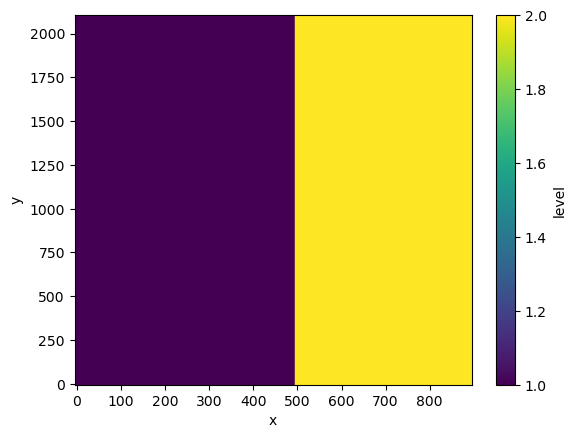

In [59]:
sf_qt.quadtree.data["level"].ugrid.plot()

In [60]:
datasets_dep = [{"elevtn":depin}]

sf_qt.setup_dep(datasets_dep=datasets_dep)

2024-03-11 10:50:32,642 - sfincs_duck_hydromt - rasterdataset - INFO - Reading  raster data from .\input_duck\delilah.tif
2024-03-11 10:50:32,707 - sfincs_duck_hydromt - rasterdataset - DEBUG - Clip to [-5.027, -5.000, 895.027, 2105.023] (epsg:32620))


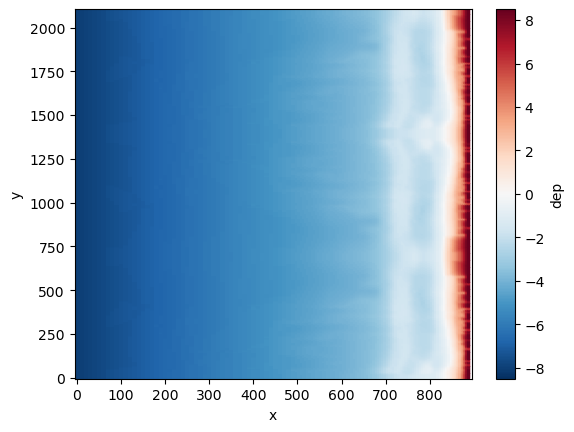

In [61]:
sf_qt.quadtree.data["dep"].ugrid.plot()

Continue with the mask for the QuadTree grid; we aim to have the same active extent as the regular grid in different ways:
- Based on elevation
- Bu using an include polygon

In [62]:
# sf_qt.quadtree.setup_mask(include_polygon=mask_include, open_boundary_polygon=open_include, open_boundary_zmax=-3)
sf_qt.quadtree.setup_mask_active(zmin=-999, zmax=999)
# sf_qt.setup_mask_active(zmin=-999, zmax=999)

In [63]:
#NOTE we lose performance through the SfincsModel, I expect this to come from the data_catalog that parses the geodataframes
# sf_qt.quadtree.setup_mask_active(gdf_include=mask_include, all_touched=False)

In [64]:
sf_qt.crs

<Projected CRS: EPSG:32620>
Name: WGS 84 / UTM zone 20N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 66°W and 60°W, northern hemisphere between equator and 84°N, onshore and offshore. Anguilla. Antigua and Barbuda. Bermuda. Brazil. British Virgin Islands. Canada - New Brunswick; Labrador; Nova Scotia; Nunavut; Prince Edward Island; Quebec. Dominica. Greenland. Grenada. Guadeloupe. Guyana. Martinique. Montserrat. Puerto Rico. St Kitts and Nevis. St Barthelemy. St Lucia. St Maarten, St Martin. St Vincent and the Grenadines. Trinidad and Tobago. Venezuela. US Virgin Islands.
- bounds: (-66.0, 0.0, -60.0, 84.0)
Coordinate Operation:
- name: UTM zone 20N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [65]:
file_name = r'./input_duck/bnd_wl_delilah_Left.pol'

open_include = utils.polygon2gdf(feats=utils.read_geoms(fn=file_name), crs=sf_qt.crs)


2024-03-11 10:50:34,768 - sfincs_duck_hydromt - geodataframe - DEBUG - Clip intersects [-67.489, -0.000, -67.481, 0.019] (EPSG:4326)


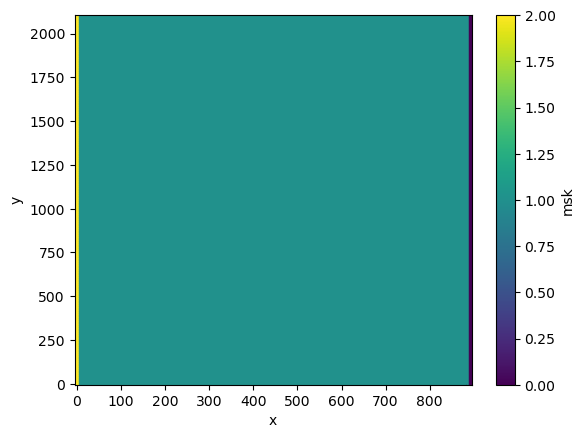

In [66]:
sf_qt.setup_mask_bounds(btype="waterlevel", zmax=0, include_mask=open_include) #

# sf_qt.grid['msk'].plot(x="x", y="y")
sf_qt.quadtree.data["msk"].ugrid.plot()

In [67]:
# plot the difference between the mask (original code) and the msk (new code)
# NOTE with all_touched=True, there is a small difference
# (sf_qt.quadtree.data["mask"]-sf_qt.quadtree.data["msk"]).ugrid.plot()

In [68]:
# drop the mask variable from the quadtree data
# sf_qt.quadtree.data = sf_qt.quadtree.data.drop("mask")

## Now some snapwave functionalities

2024-03-11 10:50:35,989 - sfincs_duck_hydromt - quadtree - INFO - Building mask ...
2024-03-11 10:50:35,990 - sfincs_duck_hydromt - quadtree - INFO - Build new mask for: snapwave ...


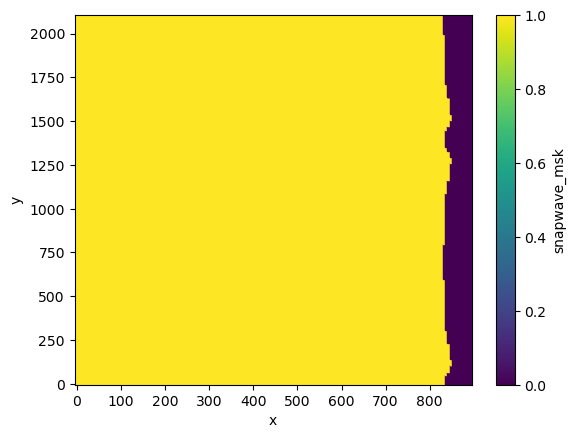

In [69]:
# sf_qt.setup_mask_active(model="snapwave", zmin=-999, zmax=2)#, include_mask=gdf_riv_buf)
# sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()
sf_qt.setup_mask_active(model="snapwave", zmin=-999, zmax=0)
sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()

Try situation where we want to directly copy the SFINCS mask to SnapWave:

In [70]:
# sf_qt.setup_mask_bounds(model="snapwave", copy_sfincsmask=True)
# sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()

### Adjust offshore wave boundary for SnapWave:

2024-03-11 10:50:36,951 - sfincs_duck_hydromt - geodataframe - DEBUG - Clip intersects [-67.489, -0.000, -67.481, 0.019] (EPSG:4326)


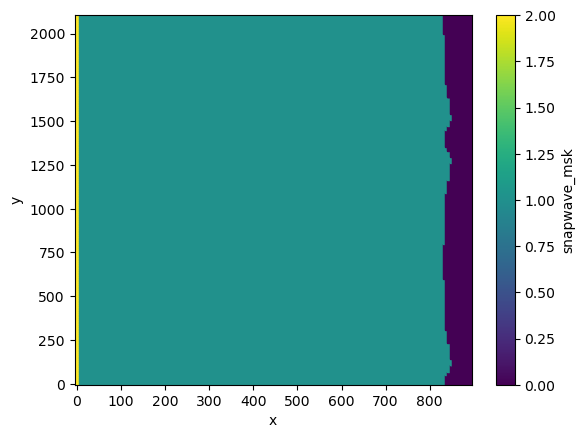

In [71]:
# %matplotlib qt
%matplotlib inline

sf_qt.setup_mask_bounds(model="snapwave", include_mask=open_include, copy_sfincsmask=False)
fig = sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()
# fig.aspect('equal', adjustable='box')


In [72]:
sf_qt.quadtree.data

<xarray.Dataset> Size: 3MB
Dimensions:        (mesh2d_nFaces: 44310)
Coordinates:
  * mesh2d_nFaces  (mesh2d_nFaces) int64 354kB 0 1 2 3 ... 44307 44308 44309
Data variables: (12/19)
    crs            int32 4B 32620
    level          (mesh2d_nFaces) int32 177kB 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2
    n              (mesh2d_nFaces) int32 177kB 1 2 3 4 5 ... 418 419 420 421 422
    m              (mesh2d_nFaces) int32 177kB 1 1 1 1 1 ... 180 180 180 180 180
    mu             (mesh2d_nFaces) int8 44kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    mu1            (mesh2d_nFaces) int32 177kB 212 213 214 215 216 ... 0 0 0 0 0
    ...             ...
    nd             (mesh2d_nFaces) int8 44kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    nd1            (mesh2d_nFaces) int32 177kB 0 1 2 3 ... 44307 44308 44309
    nd2            (mesh2d_nFaces) int32 177kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    dep            (mesh2d_nFaces) float64 354kB dask.array<chunksize=(44310,), meta=np.ndarray>
    msk            (mesh2d_nFaces) uint8 44kB 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0
    snapwave_msk   (mesh2d_nFaces) uint8 44kB 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0
Attributes:
    x0:         -5
    y0:         -5
    nmax:       211
    mmax:       90
    dx:         10.0
    dy:         10.0
    rotation:   0
    nr_levels:  2

### Now create a subgrid table for this model

In [73]:
# sf_qt.setup_subgrid(datasets_dep=datasets_dep, buffer_cells=40)

### Add some random boundary conditions

In [74]:
sf_qt.config["tref"] = "19901013 160000"
sf_qt.config["tstart"] = "19901013 160000"
sf_qt.config["tstop"] = "19901013 170000"

In [75]:
# x&y-locations in same coordinate reference system as the grid:
x = [0, 0]
y = [0, 2100]

# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1, 2]  # NOTE that the index should start at one
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf_qt.crs)

# In this case we will provide 3 values (periods=3) between the start (tstart=20100201 000000) and the end (tstop=20100201 120000) of the simulation:
time = pd.date_range(
    start=utils.parse_datetime(sf_qt.config["tstart"]),
    end=utils.parse_datetime(sf_qt.config["tstop"]),
    periods=2,
)

# add some water levels
bzs = [[0.69, 0.69], [0.69, 0.69]]

bzspd = pd.DataFrame(index=time, columns=index, data=bzs)

# Actually add it to the SFINCS model class:
sf_qt.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd)


2024-03-11 10:50:38,290 - sfincs_duck_hydromt - dataframe - DEBUG - Slicing time dime (datetime.datetime(1990, 10, 13, 16, 0), datetime.datetime(1990, 10, 13, 17, 0))
2024-03-11 10:50:38,293 - sfincs_duck_hydromt - geodataframe - DEBUG - Clip intersects [-5005.000, -5005.000, 5895.000, 7105.000] (EPSG:32620)


In [76]:
# # We now use the previously created src discharge points for the regular model
# gdf = sf.forcing["dis"].vector.to_gdf()

# # make up some discharge data
# index = sf.forcing["dis"].index
# dis = np.array([[2.0, 1.0], [5.0, 2.0], [2.0, 1.0]])
# dispd = pd.DataFrame(index=time, columns=index, data=dis)

# # now we call the function setup_discharge_forcing, which adds the discharge forcing to the src points
# sf_qt.setup_discharge_forcing(timeseries=dispd, locations=gdf)

# # # NOTE: the discharge forcing data is now stored in the sf.forcing dictionary
# sf_qt.forcing.keys()

### And save everything we build sofar

In [77]:
sf_qt.config["tspinup"]     = 60
sf_qt.config["alpha"]       = 0.5
sf_qt.config["theta"]       = 1.0

sf_qt.config["advection"]   = 1

sf_qt.config["zsini"]       = 0.69
sf_qt.config["dtout"]       = 60.0

sf_qt.config["obsfile"]     = "../input_duck/delilah_points_ext.obs"

In [78]:
#SnapWave specific settings:
sf_qt.config["dtwave"]                  = 600
sf_qt.config["storefw"]                 = 1
sf_qt.config["storewavdir"]             = 1
sf_qt.config["snapwave"]                = 1
sf_qt.config["snapwave_igwaves"]        = 1

sf_qt.config["snapwave_bndfile"]        = "../input_duck/delilah_01.bnd"
sf_qt.config["snapwave_bhsfile"]        = "../input_duck/delilah_real.bhs"
sf_qt.config["snapwave_btpfile"]        = "../input_duck/delilah_real.btp"
sf_qt.config["snapwave_bwdfile"]        = "../input_duck/delilah_real.bwd"
sf_qt.config["snapwave_bdsfile"]        = "../input_duck/delilah_real.bds"

sf_qt.config["snapwave_shinc2ig"]       = 1.0
sf_qt.config["snapwave_fw"]             = 0.0001
sf_qt.config["snapwave_fwig"]           = 0.015
sf_qt.config["snapwave_baldock_opt"]    = 1
sf_qt.config["snapwave_baldock_ratio"]  = 0.2
sf_qt.config["snapwave_baldock_ratio_ig"] = 0.2
sf_qt.config["snapwave_alpha"]          = 1.5
sf_qt.config["snapwave_alpha_ig"]       = 2.5
sf_qt.config["snapwave_gamma"]          = 0.78
sf_qt.config["snapwave_gammaig"]        = 0.2
sf_qt.config["snapwave_ig_opt"]         = 1
sf_qt.config["snapwave_hmin"]           = 0.01
sf_qt.config["snapwave_shpercig"]       = 1.0
sf_qt.config["snapwave_dtheta"]         = 10
sf_qt.config["snapwave_alphaigfac"]     = 1.0
sf_qt.config["snapwave_use_herbers"]    = 1

In [79]:
sf_qt.write()

2024-03-11 10:50:38,368 - sfincs_duck_hydromt - sfincs - INFO - Writing model data to d:\repos\hydromt_sfincs\hydromt_sfincs\examples\test_duck2
2024-03-11 10:50:38,451 - sfincs_duck_hydromt - sfincs - INFO - Write forcing files
2024-03-11 10:50:38,477 - sfincs_duck_hydromt - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2024-03-11 10:50:38,514 - sfincs_duck_hydromt - sfincs - WARNING - zsini not in states, skipping


Run and read results, make plots and animation

In [93]:
import xugrid as xu
uds = xu.open_dataset(r".\test_duck\sfincs_map.nc")

uds


<xarray.Dataset> Size: 80MB
Dimensions:        (nmesh2d_node: 177240, nmesh2d_face: 44310, time: 61,
                    timemax: 2, runtime: 1)
Coordinates:
  * time           (time) datetime64[ns] 488B 1990-10-13T16:00:00 ... 1990-10...
  * timemax        (timemax) datetime64[ns] 16B 1990-10-13T16:30:00 1990-10-1...
  * nmesh2d_face   (nmesh2d_face) int64 354kB 0 1 2 3 ... 44307 44308 44309
  * nmesh2d_node   (nmesh2d_node) int64 1MB 0 1 2 3 ... 177237 177238 177239
Dimensions without coordinates: runtime
Data variables: (12/18)
    inp            int32 4B ...
    mesh2d_node_x  (nmesh2d_node) float32 709kB ...
    mesh2d_node_y  (nmesh2d_node) float32 709kB ...
    crs            int32 4B ...
    zb             (nmesh2d_face) float32 177kB ...
    msk            (nmesh2d_face) float64 354kB ...
    ...             ...
    fwy            (time, nmesh2d_face) float32 11MB ...
    beta           (time, nmesh2d_face) float32 11MB ...
    snapwavedepth  (time, nmesh2d_face) float32 11MB ...
    total_runtime  (runtime) float32 4B ...
    average_dt     (runtime) float32 4B ...
    status         (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.8 UGRID-1.0 Delt...
    Build-Revision-Date-Netcdf-library:  4.6.1 of Mar 16 2018 14:16:08 $
    Producer:                            SFINCS model: Super-Fast INundation ...
    Build-Revision:                      $Rev: v2.0.5
    Build-Date:                          $Date: 2024-03-08
    title:                               SFINCS map netcdf output

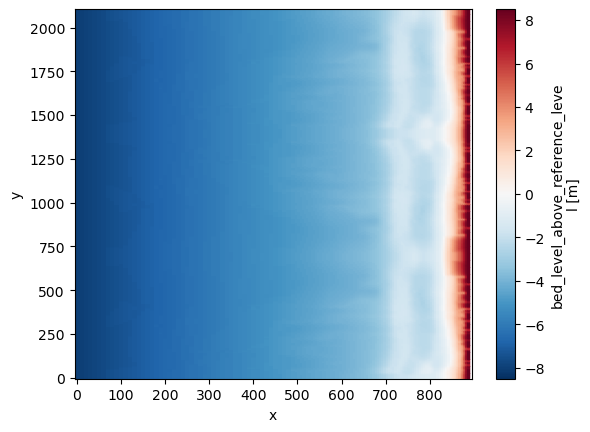

In [94]:
uds["zb"].ugrid.plot()

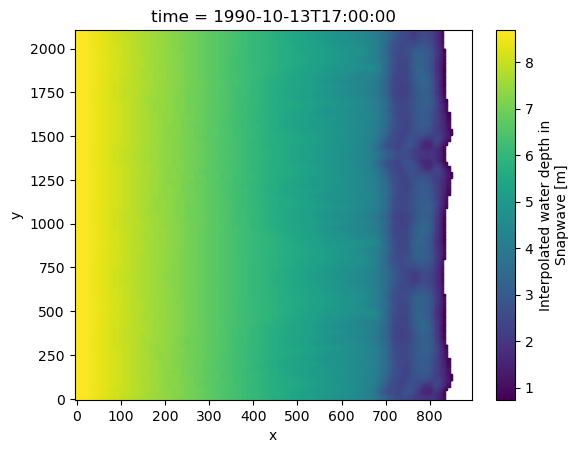

In [95]:
uds["snapwavedepth"][-1,:].ugrid.plot()

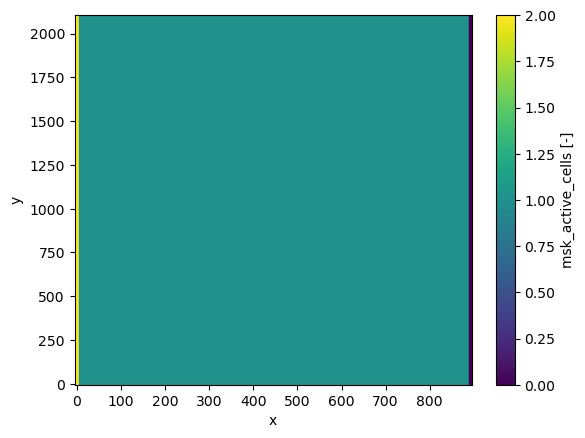

In [96]:
uds["msk"].ugrid.plot()

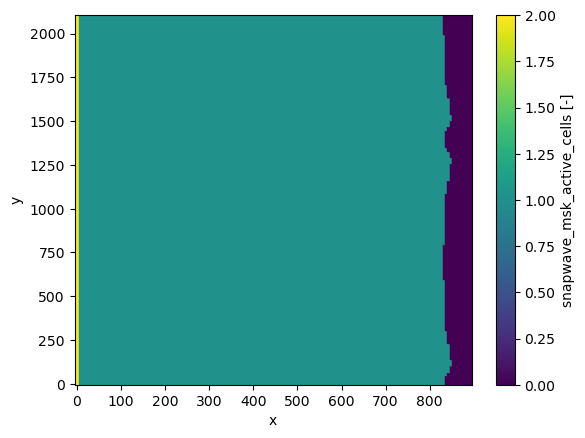

In [97]:
uds["snapwavemsk"].ugrid.plot()

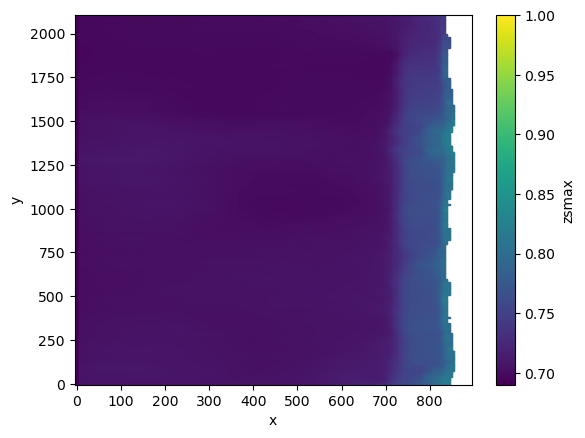

In [98]:
uds["zsmax"].max(dim="timemax").ugrid.plot(vmax=1.0)

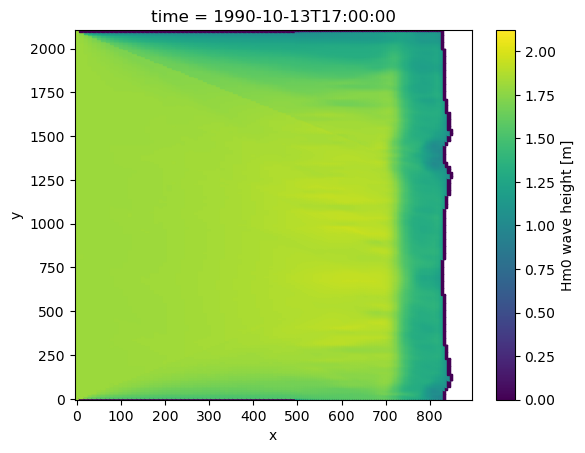

In [99]:
uds["hm0"][-1,:].ugrid.plot(vmax=1.5*np.sqrt(2))

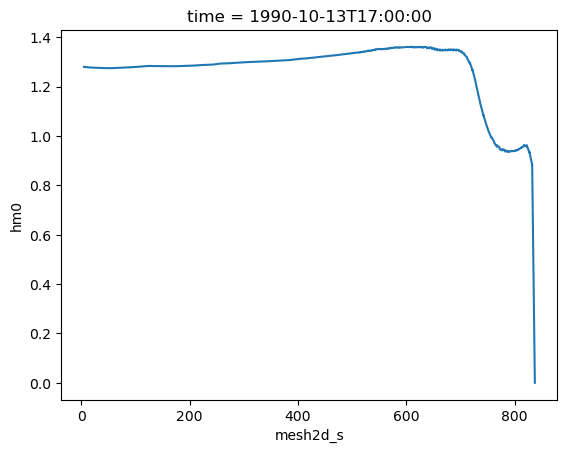

In [100]:
da = uds["hm0"][-1,:].ugrid.sel(y=1050) / np.sqrt(2)
da.plot(x="mesh2d_s")

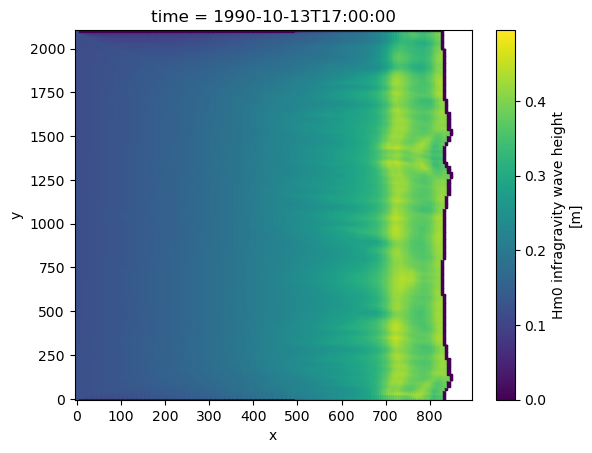

In [101]:
uds["hm0ig"][-1,:].ugrid.plot(vmax=0.35*np.sqrt(2))

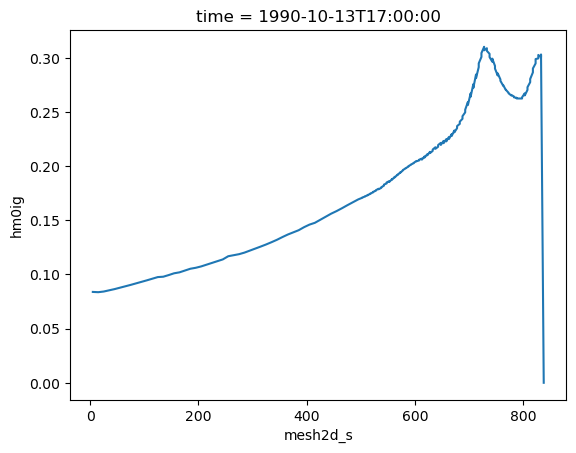

In [102]:
da = uds["hm0ig"][-1,:].ugrid.sel(y=1050) / np.sqrt(2)
da.plot(x="mesh2d_s")

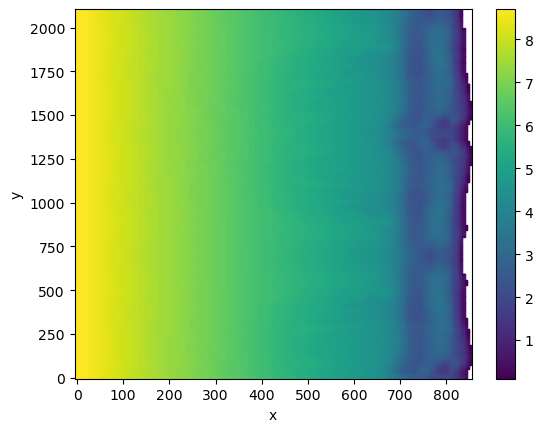

In [103]:
# plot rough estimation of water depth
h = uds["zsmax"].max(dim="timemax") - uds["zb"]

h = h[h>0.1]

h.ugrid.plot()

In [91]:
# create zs plot and save to mod.root/figs/sfincs_zs.mp4
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
da_zs = uds["zs"]

def update_plot(i, da_zs, cax_zs):
    da_zsi = da_zs.isel(time=i)
    t = da_zsi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water level {t}")
    cax_zs.set_array(da_zsi.values.ravel())

fig, ax = plt.subplots(figsize=(11, 7))
cax_zs = da_zs.isel(time=0).ugrid.plot(
    ax=ax, vmin=0, vmax=1, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_zs.time.size, step),
    interval=250,  # ms between frames
    fargs=(
        da_zs,
        cax_zs,
    ),
)

# to save to mp4
# ani.save(join(mod.root, 'figs', 'sfincs_h.mp4'), fps=4, dpi=200)

# to show in notebook:
from IPython.display import HTML

HTML(ani.to_html5_video())

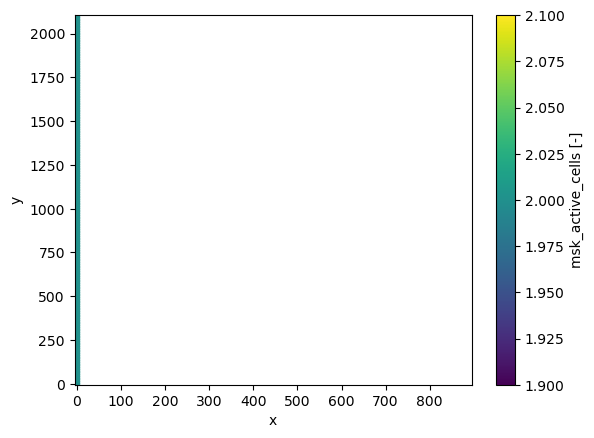

In [92]:
uds["msk"].where(uds["msk"]==2, np.nan).ugrid.plot()